In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

from utils import get_background, get_events, get_track_event, insert_date, insert_gender, drop_null_target, trim

# 設定顯示格式與路徑
pd.options.display.float_format = '{:.4f}'.format
FIG_PATH = Path('/home/cmc1503/Desktop/JD_exploration/figures')
DATA_PATH = Path('/home/cmc1503/Desktop/JD_exploration/data')

# 設定中文字型
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties as font
font_path = Path('/home/cmc1503/Desktop/Noto_Sans_TC/static/NotoSansTC-Regular.ttf')
font_manager.fontManager.addfont(font_path)
prop = font(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

## Part 1: User Background

### Functions

In [17]:
# Local Helper Functions

def ts_to_datetime(data, dt=True):
    """將 timestamp 欄位轉換為日期"""
    datetime_col = data.apply(lambda x: datetime.fromtimestamp(x))
    if dt:
        return datetime_col.dt.date
    else:
        return datetime_col 

def cal_age(birthdate):
    """根據生日計算年齡"""
    if birthdate > pd.Timestamp.today():
        return np.nan # 處理尚未出生或錯誤日期
    else:
        return relativedelta(date.today(), birthdate).years

# --- 累積使用者計算函式 ---
def get_cum_user(data, col, asending=False):
    """
    計算指定欄位的 value_counts 並回傳 CUMSUM
    """
    cum_user = data[col].value_counts().sort_index(ascending=asending).cumsum()
    cum_user.sort_index(inplace=True)
    cum_user.index = cum_user.index.map(str) # 轉為 string, 繪圖時 x 軸為類別
    return cum_user

# --- 累積使用者繪圖函式 ---
def get_cum_plot(data, cum_user, col, cum_label=None, cnt_label=None, title=None, savefig=False):
    """
    (來自 all_backgrounds.ipynb)
    繪製 雙軸組合圖 (線圖: 累積計數, 長條圖: 原始計數)
    """
    fig = plt.figure(figsize=(16, 9))
    
    # Ax1: 累積線圖
    ax1 = sns.lineplot(data=cum_user, color='r', label=cum_label)
    
    # Ax2: 原始計數長條圖
    ax2 = ax1.twinx()
    sns.barplot(data[col].value_counts(), alpha=.5, width=.6, label=cnt_label, ax=ax2)

    ax2.set_xticks(np.arange(101, 0, -12))
    ax1.set_xlabel(col, labelpad=15, fontdict={'fontsize': 14})
    ax1.set_ylabel(cum_label, labelpad=15, fontdict={'fontsize': 14})
    ax2.set_ylabel(cnt_label, labelpad=15, fontdict={'fontsize': 14})
    ax1.legend(loc='upper left', prop={'size': 12}, framealpha=.3)
    ax2.legend(loc='upper right', prop={'size': 12}, framealpha=.3)
    ax1.tick_params(labelsize=12)
    ax2.tick_params(labelsize=12)

    ax1.grid()

    if savefig:
        # 確保 '0808' 資料夾存在 (來自您的原始碼)
        (FIG_PATH / 'EDA_User_Activity').mkdir(exist_ok=True) 
        plt.savefig(FIG_PATH / 'EDA_User_Activity' / title, dpi=250)
    
    plt.show()
    return

# --- 特徵分佈繪圖函式 ---
def get_char_dist(data, filt, col, title=None, savefig=False):
    y = data[filt][col].value_counts()

    fig = plt.figure(figsize=(12, 8))
    ax = sns.barplot(y)
    ax.set_ylabel('Count', fontdict={'fontsize': 14}, labelpad=15)
    ax.set_xlabel(col, fontdict={'fontsize': 14}, labelpad=15)
    ax.set_xticklabels(sorted(y.index), rotation=60, fontdict={'fontsize': 8})
    ax.set_title(title, fontsize=16)

    if savefig:
        (FIG_PATH / 'EDA_User_Activity').mkdir(exist_ok=True) # 確保資料夾存在
        plt.savefig(FIG_PATH / 'EDA_User_Activity' / title, dpi=250)
    
    plt.show() 
    return

def get_reg_date(data):
    reg_date = ts_to_datetime(data['reg_ts'], False)
    return reg_date

# --- City 相關 ---
def get_city_cnts(data, include_1=False):
    country_filt = data['country'] == 1
    
    if include_1:
        # city 包括 0, 1
        city_filt = data['city'].isin(list(range(100, 126)) + [0, 1])
    else:
        # city 不包括 0, 1
        city_filt = data['city'].isin(range(100, 126))
    
    city_cnts = data['city'][country_filt & city_filt].value_counts().sort_index(ascending=True)
    return city_cnts

def get_city_reg_time(data, last):
    city_cnts = get_city_cnts(data, True)

    if last:
        # 最晚註冊時間
        reg_time = pd.DataFrame(pd.to_datetime(data.groupby('city')['reg_ts'].max()[:25], unit='s'))
    else:
        # 最早註冊時間
        reg_time = pd.DataFrame(pd.to_datetime(data.groupby('city')['reg_ts'].min()[:25], unit='s'))
    
    df = pd.concat([pd.DataFrame(reg_time), city_cnts], axis=1)
    return df

def combine_city_reg_time(female_data, male_data, all_data, last):
    female_df = get_city_reg_time(female_data, last=last).rename(
        columns={'reg_ts': 'reg_ts_F', 'count': 'count_F'}
        )
    male_df = get_city_reg_time(male_data, last=last).rename(
        columns={'reg_ts': 'reg_ts_M', 'count': 'count_M'}
        )
    all_df = get_city_reg_time(all_data, last=last).rename(
        columns={'reg_ts': 'reg_ts_All', 'count': 'count_All'}
        )
    
    df = pd.concat([male_df, female_df, all_df], axis=1)
    return df

# --- Pie chart 相關 ---
def autopct_more_than_p(pct):
    """圓餅圖輔助：只顯示 > 5% 的百分比"""
    return '{:.1f}%'.format(pct) if pct >= 5 else ''

def get_city_pie(city_cnts, title, savefig=False):
    """
    繪製城市分佈的圓餅圖
    """
    sizes = city_cnts / city_cnts.sum()
    
    # labels, >= 5% -> show label
    labels = []
    for i, p in zip(sizes.index, sizes):
        if p >= .05:
            labels.append(i)
        else:
            labels.append('')

    fig = plt.figure(figsize=(12, 8))
    plt.pie(city_cnts, labels=labels, autopct=autopct_more_than_p)

    labels_legend = [f'{l} ({s:.1%})' for l, s in zip(city_cnts.index, sizes)]
    plt.legend(labels=labels_legend, bbox_to_anchor=(1, 0.9))
    plt.title(title, fontdict={'fontsize': 16}, x=0.6, y=0.95)

    if savefig:
        plt.savefig(FIG_PATH / '1014' / f'{title}.png', bbox_inches='tight', dpi=500)
    
    plt.show()
    return

### Analysis

In [ ]:
# 載入與預處理資料

# 1. 載入資料
dataname = 'females'
data = pd.read_csv(DATA_PATH / f'users_{dataname}.csv')
male_data = pd.read_csv(DATA_PATH / f'users_males.csv')
all_data = pd.concat([male_data, data])

# 2. 處理 'age'
total_number = len(data.uCode)
above_70 = len(data.age[data.age >= 70]) / total_number
below_0 = len(data.age[data.age <= 0]) / total_number
# print(f'==== {dataname} Age 離群值 ====')
# print(f'"{dataname}", ">=70": {above_70: .2%}, "<=0: {below_0: .2%}", Total: {total_number}')

# 3. 處理 'reg_ymd'
data['reg_ymd'] = get_reg_date(data).dt.strftime('%Y%m')
male_data['reg_ymd'] = get_reg_date(male_data).dt.strftime('%Y%m')

# 4. 建立篩選條件 
login_filt = data['last_login_ymd'] >= 202307
reg_filt = data['reg_ymd'].apply(int) >= 202307

m_login_filt = male_data['last_login_ymd'] >= 202307
m_reg_filt = male_data['reg_ymd'].apply(int) >= 202307

In [ ]:
# 累積註冊使用者 (Female)
cum_user_reg = get_cum_user(data, col='reg_ymd', asending=True)

get_cum_plot(
    data, 
    cum_user=cum_user_reg, 
    col='reg_ymd',
    cum_label='Cumulative Count of Newly-registered Users',
    cnt_label='Count of Newly-registered Users',
    title='cnt_new_reg_users (Female)',
    savefig=False
)

# 累積最後登入 (Female)
cum_user_login = get_cum_user(data, col='last_login_ymd', asending=False)

get_cum_plot(
    data, 
    cum_user=cum_user_login, 
    col='last_login_ymd',
    cum_label='Cumulative Count of "last-login" Users',
    cnt_label='Count of "last-login" Users',
    title='cnt_last_log_users (Female)',
    savefig=False
)

# 特徵分布
# Age
get_char_dist(data, login_filt, 'age', 'F_age_dist_after_202307', False)

# Height
get_char_dist(data, (data['height'] > 0), 'height', 'F_height_dist', False)

In [ ]:
# City 相關

# 顯示各城市最早註冊時間
print("==== 城市分析 (最早註冊時間) ====")
print(combine_city_reg_time(data, male_data, all_data, last=False).to_latex(escape=True))

# 顯示各城市最晚註冊時間
print("==== 城市分析 (最晚註冊時間) ====")
print(combine_city_reg_time(data, male_data, all_data, last=True).to_latex(escape=True))

# 城市分佈圓餅圖 (Female)
city_cnts_f = get_city_cnts(data)
get_city_pie(city_cnts_f, title='city_pie_all (Female Users)', savefig=False)


## Part 2: User Activity

### 2-1: `track_event`

### Functions

In [ ]:
# Local Helper Functions

from pyarrow import feather

def get_all_track_event_with_stars():
    """
    讀取 feather 檔案
    """
    # df = feather.read_feather(path / 'all_track_event_after_cleared_fem_meet_with_stars.feather')

    # 此檔案為清除過 missing values 的資料，並且 act 只有 'meet'，且只有女性的資料
    # 有「先前」的行為
    df = feather.read_feather(DATA_PATH / 'all_track_event_after_cleared_fem_meet_with_stars_and_prev.feather')
    return df

# def trim_by_act(data, act='interestYes', bound=0.999, show_outliers=False):
#     """根據 track_event 的 'act' 欄位移除離群值"""
#     df = data[['uCode', 'act']].groupby(['uCode', 'act']).value_counts()
#     lis = data.act.unique()
#     act_counts_by_uCode = df.unstack()[lis].fillna(0)
#     filt = act_counts_by_uCode[act] < act_counts_by_uCode[act].quantile(bound)
#     neg_filt = act_counts_by_uCode[act] >= act_counts_by_uCode[act].quantile(bound)
#     outliers = act_counts_by_uCode[neg_filt].index
    
#     if show_outliers:
#         return act_counts_by_uCode[neg_filt]
#     else:
#         return data[~data.uCode.isin(outliers)]

def get_missing_data(df, target_only=False):
    """
    獲取 track_event 中，act 為空白的子集。
    
    Args:
        df (pd.DataFrame): track_event 的資料.
        target_only (str, optional): 是否要包括 target_uCode 也空白的. 預設為 'F'.
    
    Returns:
        pd.DataFrame: 輸入 df 中，act 為空白的子集.
    """
    act_filt = df.act.isna()
    target_filt = df.target_uCode.isna()
    if target_only:
        return df[target_filt]
    else:
        return df[act_filt & target_filt]

def get_pie_chart(df, col='page'):
    """
    繪制圓餅圖，預設以 'page' 欄作為分類.

    Args:
        df: (pd.DataFrame): track_event 的資料.
        col (str, optional): 作為分類的 column. 預設為 'page'. 
    """
    
    x = df[col].value_counts()
    sizes = x / x.sum()
    labels = [f'{l} ({s:.1%})' for l, s in zip(x.index, sizes)]
    top_labels = [f'{l} ({s:.1%})' if s > 0.05 else '' for l, s in zip(x.index, sizes)]
    
    fig, ax = plt.subplots()
    ax.pie(x, labels=top_labels)
    ax.legend(labels=labels, bbox_to_anchor=(1.8,1.2))
    ax.set_title(f"Pie Chart of {col}")
    return fig, ax

### Analysis

In [9]:
# 載入資料
female_uCode = get_background(columns=['uCode', 'gender'], gender='F')
male_uCode = get_background(columns=['uCode', 'gender'], gender='M')
all_uCode = pd.concat([female_uCode, male_uCode], axis=0)

track_data = get_all_track_event_with_stars()

# 加入 gender, date 欄
track_data = insert_date(track_data)
track_data = insert_gender(track_data, female_uCode)
female_track_data = track_data[track_data.gender == 'F']

In [ ]:
# 遺失值 (Missing Data) 分析
# 以 Week 1 為例
# 上面的 track_data 是已經清除過 missing values 的資料

week1_df = get_track_event(1, 1)
week1_df = insert_gender(week1_df, all_uCode)
week1_f_df = week1_df[week1_df.gender == 'F']

missing_df = get_missing_data(week1_df, target_only=False)
missing_f_df = get_missing_data(week1_f_df, target_only=False)

# 計算各個 'page' 的遺失比例，分成全部用戶的 track_event 和女性用戶的 track_event
missing_by_page_dict = dict(missing_df.page.value_counts())
num_by_page_dict = dict(week1_df.page.value_counts())
missing_by_page_dict_f = dict(missing_f_df.page.value_counts())
num_by_page_dict_f = dict(week1_f_df.page.value_counts())

# 全部用戶
missing_ratio_dict = {i: missing_by_page_dict[i] / num_by_page_dict[i] for i in missing_by_page_dict}
print(pd.DataFrame(missing_ratio_dict, index=['percentage']).T.sort_values(by='percentage', ascending=False))

# 女性用戶
missing_ratio_dict_f = {i: missing_by_page_dict_f[i] / num_by_page_dict_f[i] for i in missing_by_page_dict_f}
print(pd.DataFrame(missing_ratio_dict_f, index=['percentage']).T.sort_values(by='percentage', ascending=False))

# 繪成圓餅圖，以 'page' 分類
get_pie_chart(missing_f_df)
get_pie_chart(week1_f_df)

In [ ]:
# Page 與 Gender 分析
# 以 Week 1 為例

# Pie chart of 'page'
get_pie_chart(week1_f_df)

# Pie chart of 'gender'
# 篩選 'act' 非 NaN 並取出 unique 'uCode'
na_filt = (~week1_df['act'].isna())
df_gender = week1_df[na_filt][['uCode', 'ts', 'gender']].copy(deep=True)
df_gender.drop_duplicates(subset=['uCode'], inplace=True)

# 繪製使用者的性別比例（含實際數字），去除掉只有 nan act 的使用者
fig, ax = plt.subplots()
x = df_gender['gender'].value_counts()
labels = [f'{l}: {s}' for l, s in zip(x.index, x)]
ax.pie(x, labels=labels, autopct='%1.0f%%', pctdistance=0.3, labeldistance=0.55)
ax.set_title("Gender Distribution (Unique Users (uCode), act != NaN)")
plt.show()

In [ ]:
# 男性用戶收到的 interestYes/interestNo
# 以 Week 1 為例

# 只考慮有收到 interestYes/interestNo 的用戶
male_users = pd.DataFrame(week1_f_df['target_uCode'].unique(), columns=['male_user'])

# 每個男性用戶各自收到的 interestYes
interestYes_cnt = week1_f_df[week1_f_df['act'] == 'interestYes'].groupby('target_uCode')['act'].count()
male_users['interestYes'] = male_users['male_user'].map(dict(interestYes_cnt))
male_users['interestYes'] = male_users['interestYes'].fillna(0).apply(int)

# 每個男性用戶各自收到的 interestNo
interestNo_cnt = week1_df[week1_df['act'] == 'interestNo'].groupby('target_uCode')['act'].count()
male_users['interestNo'] = male_users['male_user'].map(dict(interestNo_cnt))
male_users['interestNo'] = male_users['interestNo'].fillna(0).apply(int)

# 每個男性用戶各自收到的 Yes/No
male_users['received_act'] = male_users['interestYes'] + male_users['interestNo']
male_users['yes_ratio'] = male_users['interestYes'] / male_users['received_act']
male_users['yes_ratio'].fillna(0, inplace=True) # 處理 received_act = 0

# 統計
print(f"收過 interestYes/interestNo 的男性使用者總數: {male_users['male_user'].nunique()}")
print(f"沒收過 'interestYes' 的比例: {(male_users['interestYes'] == 0).sum() / male_users['male_user'].nunique():.2%}")

# 考慮收過 Yes/No 總數 >= 10 的用戶
received_filt = male_users['received_act'] >= 10
print(f"--- 考慮 'received_act' >= 10 的使用者) ---")
print(f"總人數: {male_users[received_filt]['male_user'].nunique()}")

# 繪製男性收到 'interestYes' *次數* (Count) 的直方圖
plt.figure()
hist = plt.hist(male_users['interestYes'], bins=range(0, 101, 10))
plt.xticks(hist[1], range(0, 101, 10))
plt.xlabel('Count of interestYes (Received by Males)', labelpad=10)
plt.ylabel('Count of Male Users', labelpad=10) 
plt.title('Histogram of Received interestYes')
plt.show()

<BarContainer object of 10 artists>

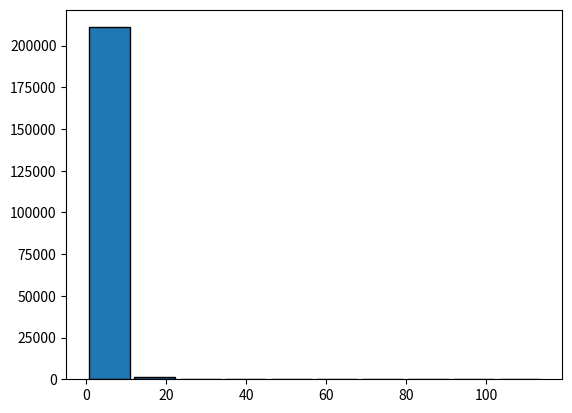

In [27]:
counts, bin_edges = np.histogram(male_users['interestYes'], bins=10)
bin_widths = np.diff(bin_edges)
bin_centers = bin_edges[:-1] + bin_widths / 2

plt.bar(bin_centers, counts, width=bin_widths * 0.9, 
        edgecolor='black', align='center')
